# Classifier features analysis

In [1]:
from pandas import read_csv
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing, metrics, feature_selection
from sklearn.pipeline import Pipeline
import seaborn as sns
sns.set(color_codes=True)
from sklearn.externals import joblib
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn import svm

path_data = ("data/")

In [2]:
def describe_dataset(Y):
    print('Original dataset shape {}'.format(Counter(Y)))
    
def correlation_plot(data):    
    corr = data.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, ax=ax, linewidths=.5, cmap=plt.cm.Spectral_r, mask=mask)
    
def kfold_validation(clf, X, Y_true, sampler, splits_count=10):
    k_fold = StratifiedKFold(n_splits=splits_count)
    auc_scores = []
    f1_scores = []
    for train, test in k_fold.split(X, Y_true):
        #describe_dataset(Y_true[train])

        # Data sampling
        #X_train, Y_train= sampler.fit_sample(X[train], Y_true[train])
        X_train, Y_train = X[train], Y_true[train]

        #describe_dataset(Y_train)
        clf.fit(X_train, Y_train)
        predictions = clf.predict_proba(X[test])[:, 1]
        threshold = find_threshold_auc(Y_true[test], predictions)
        predictions[predictions > threshold] = 1
        predictions[predictions <= threshold] = 0
        print(metrics.precision_recall_fscore_support(Y_true[test], predictions))
        auc_scores.append(metrics.roc_auc_score(Y_true[test], predictions, average="weighted"))
        f1_scores.append(metrics.f1_score(Y_true[test], predictions, average='weighted'))
    auc_scores = np.array(auc_scores)
    f1_scores = np.array(f1_scores)
    print("%d-fold AUC: %0.2f (+/- %0.2f)" % (splits_count, auc_scores.mean(), auc_scores.std()))
    print("%d-fold F1: %0.2f (+/- %0.2f)" % (splits_count, f1_scores.mean(), f1_scores.std()))
    
def find_threshold_auc(Y_true, Y_pred_prob):
    thresholds = np.arange(0.01, 1.0, 0.01)
    best_threshold = 0.5
    maximum = 0
    for t in thresholds:
        y = np.copy(Y_pred_prob)
        y[Y_pred_prob > t] = 1
        y[Y_pred_prob <= t] = 0
        current_auc = metrics.roc_auc_score(Y_true, y, average='weighted')
        if current_auc > maximum:
            maximum = current_auc
            best_threshold = t
    return best_threshold
    
def features_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
def report(results, n_top=3):
    '''
    Utility function to report best scores
    :param results:
    :param n_top:
    :return:
    '''
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
    
def grid_searching(clf, X, Y, param_grid, cv):
        print('Grid searching...')
        grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv,
                                   scoring=metrics.make_scorer(metrics.roc_auc_score, average='weighted'))
        grid_search.fit(X, Y)
        report(grid_search.cv_results_)
        # Use best estimator
        return grid_search.best_estimator_
    
def evaluate_classifier(base_clf, X, Y, param_grid, cv):
    scaler = preprocessing.RobustScaler()
    pipelined_clf = Pipeline([('scaler', scaler), ('clf', base_clf)])
    
    # Grid searching of best hyper parameters
    pipelined_clf = grid_searching(pipelined_clf, X, Y, PARAM_GRID, cv)

    # Report k-fold validation
    kfold_validation(pipelined_clf, X, Y, None, splits_count=cv)
    
    # Train, test split. Report histogram of predictions.
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.70, stratify=Y, random_state=42)
    pipelined_clf.fit(X_train, Y_train)
    predictions =pipelined_clf.predict_proba(X_test)[:, 1]
    predicted_prob_histogram(predictions)
    auc_thresholds_plot(Y_test, predictions)
    roc_curve(Y_test, predictions)

    # Train on full dataset and report OOB score
    pipelined_clf.fit(X, Y)
    return pipelined_clf

def auc_thresholds_plot(Y_true, Y_pred_prob):
    thresholds = np.arange(0.1, 1.0, 0.1)
    scores = []
    for t in thresholds:
        y = np.copy(Y_pred_prob)
        y[Y_pred_prob > t] = 1
        y[Y_pred_prob <= t] = 0
        current_auc = metrics.roc_auc_score(Y_true, y, average='weighted')
        scores.append(current_auc)
    plt.plot(thresholds, scores)
    plt.xlabel("Threshold")
    plt.ylabel("AUC")
    plt.show()

def predicted_prob_histogram(y_pred_prob):
    plt.hist(y_pred_prob, bins=10)
    plt.xlabel("Predicted probability")
    plt.ylabel("Frequency")
    plt.show()
    
def roc_curve(Y_true, Y_pred_prob):
    fpr, tpr, thresholds = metrics.roc_curve(Y_true, Y_pred_prob, pos_label=1, drop_intermediate=False)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("ROC curve")
    plt.xlabel("FPR (1 - Specificity)")
    plt.ylabel("TPR (Sensitivity)")
    plt.grid(True)
    plt.show()
    
def select_features(X, Y):
    scores, pvaues = feature_selection.f_classif(X, Y)
    print('ANOVA f-values: ', scores)
    print('ANOVA p-values: ', pvaues)

In [3]:
exp_features = ['Cosine sim', 'Answers week','Answers topic', 'Votes topic', 'Votes week',
                'Knowledge gap topic', 'Knowledge gap week', 'Knowledge gap', 'Seen week lectures', 
                'Seen topic lectures', 'Grade']
exp_data = read_csv(path_data+'expertise-train.dat', delimiter=' ', header=None, names = ['Class']+exp_features)
#exp_data.head()
describe_dataset(exp_data['Class'])
exp_data.describe()

Original dataset shape Counter({1: 134, 0: 50})


,Class,Cosine sim,Answers week,Answers topic,Votes topic,Votes week,Knowledge gap topic,Knowledge gap week,Knowledge gap,Seen week lectures,Seen topic lectures,Grade
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,0.728261,0.275205,2.500000,1.173913,0.407609,1.494565,1.440217,3.146739,19.326087,1.408044,1.502135,0.187421
std,0.446070,0.195891,3.968455,2.895667,1.363917,3.446702,3.447770,6.057574,33.501198,2.189116,2.263753,0.346621
min,0.000000,0.036991,0.000000,0.000000,0.000000,-1.000000,-2.000000,-10.000000,-42.000000,0.000000,0.000000,0.000000
25%,0.000000,0.131647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.211555,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,0.333333,0.464286,0.000000
75%,1.000000,0.364576,3.000000,1.000000,0.000000,2.000000,1.000000,5.000000,25.000000,2.059524,2.125000,0.080127
max,1.000000,0.982510,23.000000,19.000000,15.000000,23.000000,21.000000,32.000000,121.000000,13.333333,13.000000,1.000000


### Correlation between expertise input features

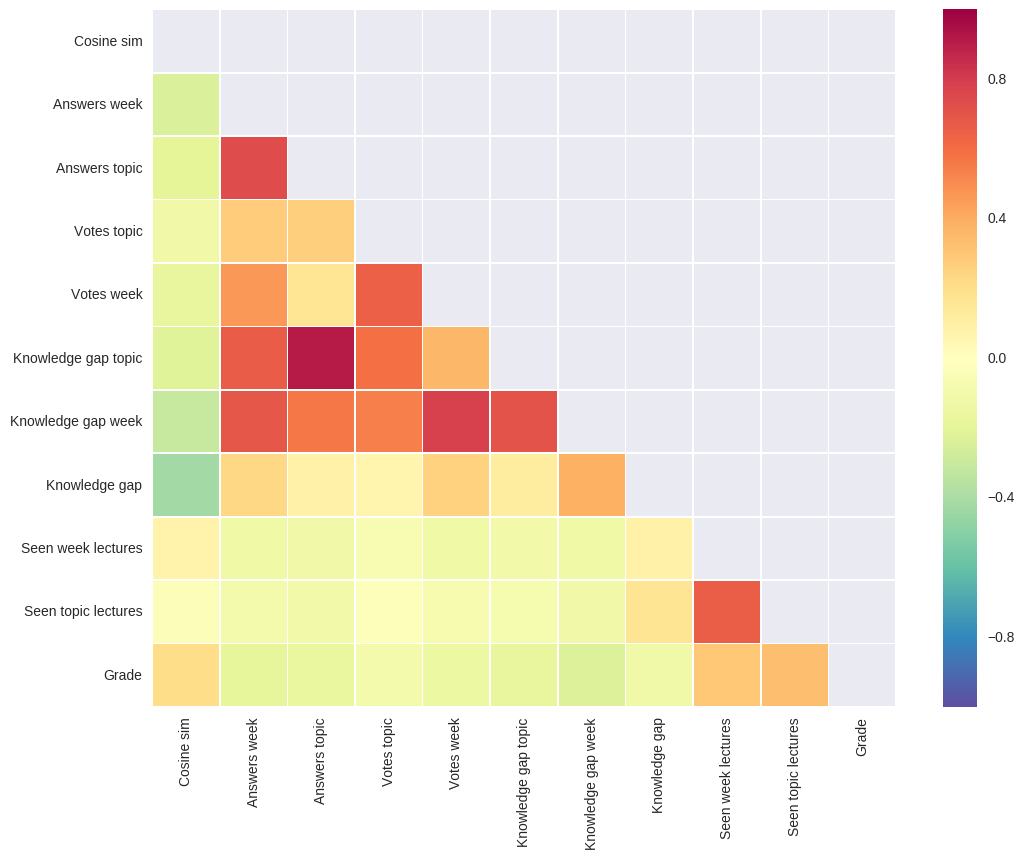

In [4]:
correlation_plot(exp_data.drop('Class', axis=1))

### Anova input features and output classes

In [5]:
Y = exp_data['Class'].as_matrix()
X = exp_data.drop('Class', axis=1).as_matrix()
select_features(X, Y)

('ANOVA f-values: ', array([ 4.60312748,  0.        ,  0.57840385,  0.00563605,  0.01711467,
        0.83229727,  0.79758743,  0.00646941,  0.25450774,  0.0396085 ,
        0.1342262 ]))
('ANOVA p-values: ', array([ 0.03323885,  1.        ,  0.44792279,  0.94023858,  0.89605978,
        0.36281594,  0.37299502,  0.93598152,  0.614529  ,  0.84247016,
        0.71451534]))


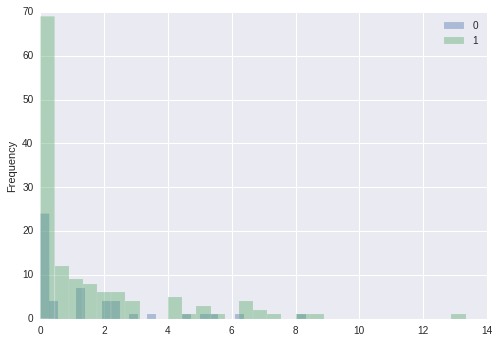

In [19]:
plt.figure()
exp_data.groupby('Class')['Seen week lectures'].plot.hist(alpha=0.4, bins=30, legend=True)
plt.show()

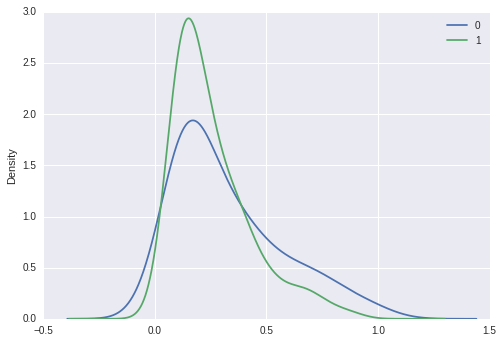

In [20]:
plt.figure()
exp_data.groupby('Class')['Cosine sim'].plot(kind='density', legend=True)
plt.show()

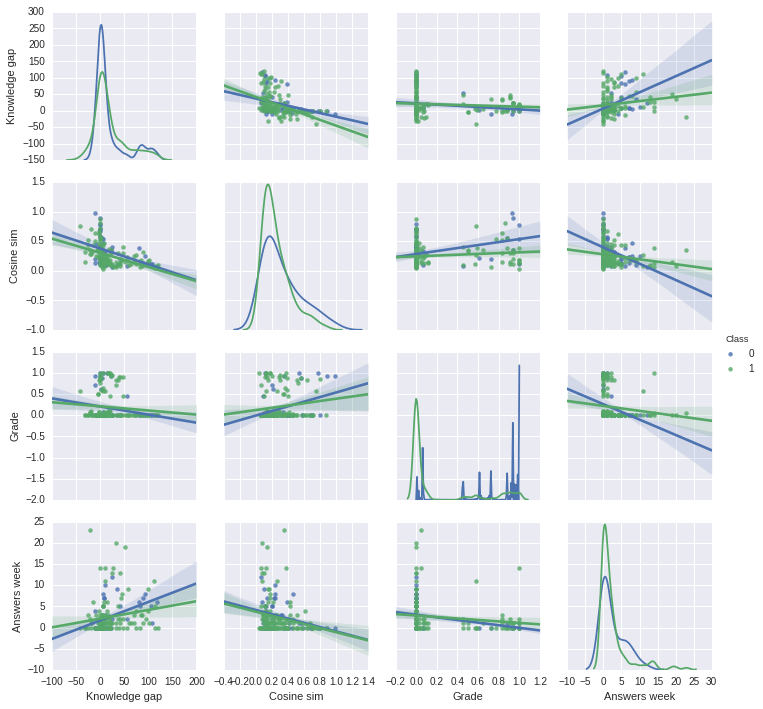

In [218]:
sns.pairplot(exp_data, hue="Class", vars=["Knowledge gap", "Cosine sim", 'Grade', 'Answers week'], 
             kind="reg", diag_kind="kde")

### Expertise training

Grid searching...
Model with rank: 1
Mean validation score: 0.619 (std: 0.075)
Parameters: {'clf__n_estimators': 100, 'clf__oob_score': True, 'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__random_state': 42, 'clf__class_weight': 'balanced'}

Model with rank: 2
Mean validation score: 0.618 (std: 0.084)
Parameters: {'clf__n_estimators': 60, 'clf__oob_score': True, 'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__random_state': 42, 'clf__class_weight': 'balanced'}

Model with rank: 3
Mean validation score: 0.613 (std: 0.086)
Parameters: {'clf__n_estimators': 200, 'clf__oob_score': True, 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__random_state': 42, 'clf__class_weight': 'balanced'}

(array([ 0.57142857,  0.8       ]), array([ 0.44444444,  0.86956522]), array([ 0.5       ,  0.83333333]), array([ 9, 23]))
(array([ 0.31034483,  1.        ]), array([ 1.        ,  0.13043478]), array([ 0.47368421,  0.23076923]), array([ 9, 23]))
(array([ 0.46153846,  0.88235294]), array([ 

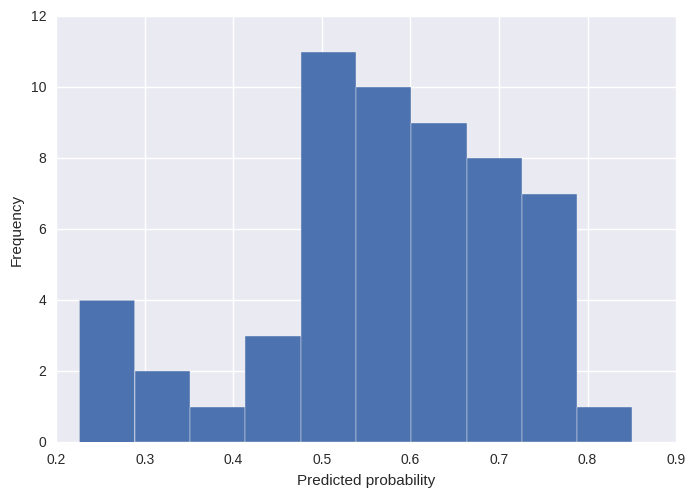

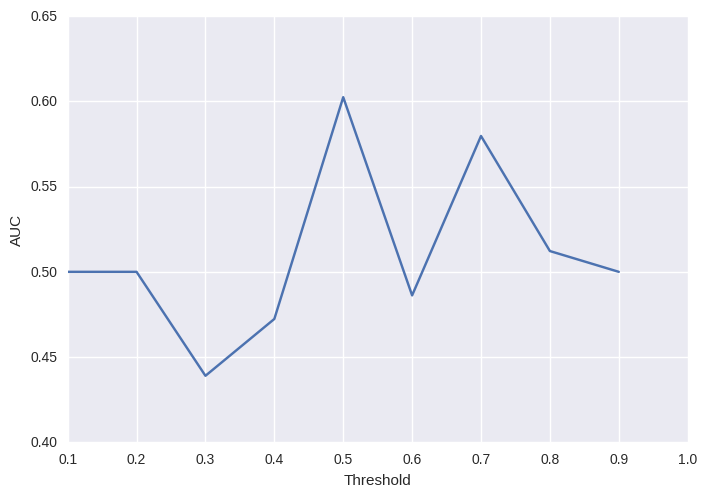

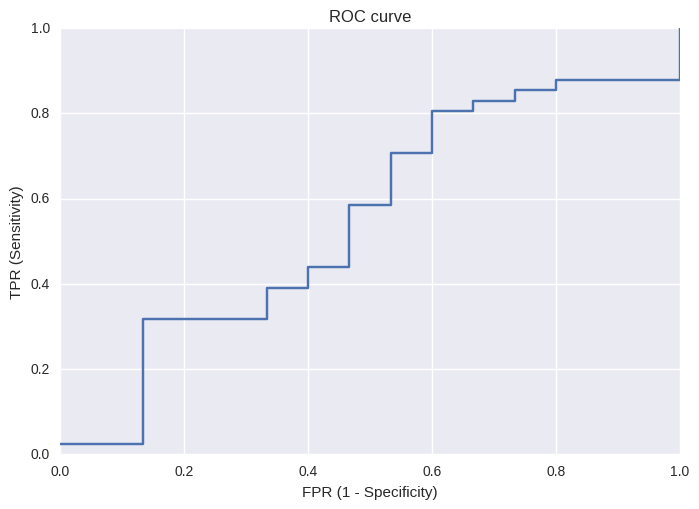

('OOB Score:', 0.66847826086956519)


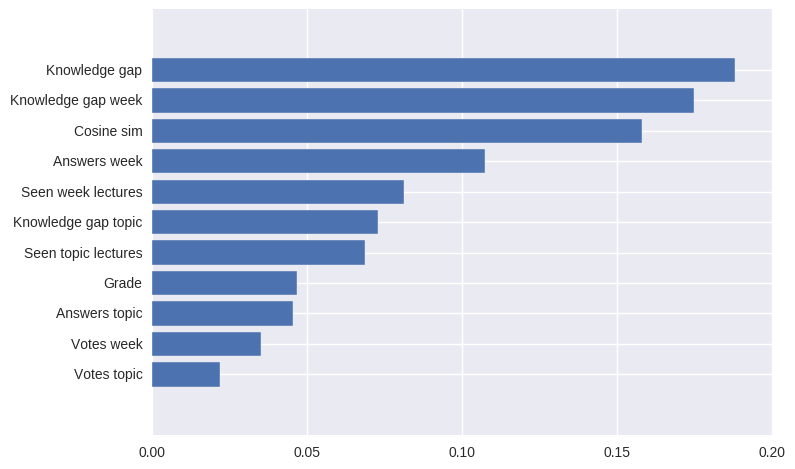

In [6]:
Y = exp_data['Class'].as_matrix()
X = exp_data.drop('Class', axis=1).as_matrix()

classifier = RandomForestClassifier()
PARAM_GRID = {
            "clf__n_estimators": [60, 100, 200],
            "clf__criterion": ["gini", "entropy"],
            "clf__max_depth": [2, 3, 4, 5, 6],
            "clf__oob_score": [True],
            "clf__class_weight": ["balanced"],
            "clf__random_state": [42]
}

clf = evaluate_classifier(classifier, X, Y, PARAM_GRID, 6)
print('OOB Score:', clf.named_steps['clf'].oob_score_)
# Plot feature importances
features_importances(clf.named_steps['clf'].feature_importances_, exp_data.drop('Class', axis=1))

Grid searching...
Model with rank: 1
Mean validation score: 0.587 (std: 0.103)
Parameters: {'clf__n_iter': 100, 'clf__loss': 'log', 'clf__random_state': 42, 'clf__penalty': 'l1', 'clf__class_weight': 'balanced', 'clf__alpha': 0.01}

Model with rank: 2
Mean validation score: 0.569 (std: 0.050)
Parameters: {'clf__n_iter': 100, 'clf__loss': 'log', 'clf__random_state': 42, 'clf__penalty': 'l2', 'clf__class_weight': 'balanced', 'clf__alpha': 0.001}

Model with rank: 3
Mean validation score: 0.559 (std: 0.084)
Parameters: {'clf__n_iter': 500, 'clf__loss': 'log', 'clf__random_state': 42, 'clf__penalty': 'l1', 'clf__class_weight': 'balanced', 'clf__alpha': 0.0001}

(array([ 0.5       ,  0.88888889]), array([ 0.77777778,  0.69565217]), array([ 0.60869565,  0.7804878 ]), array([ 9, 23]))
(array([ 0.375,  0.75 ]), array([ 0.33333333,  0.7826087 ]), array([ 0.35294118,  0.76595745]), array([ 9, 23]))
(array([ 0.5       ,  0.79166667]), array([ 0.375     ,  0.86363636]), array([ 0.42857143,  0.8260

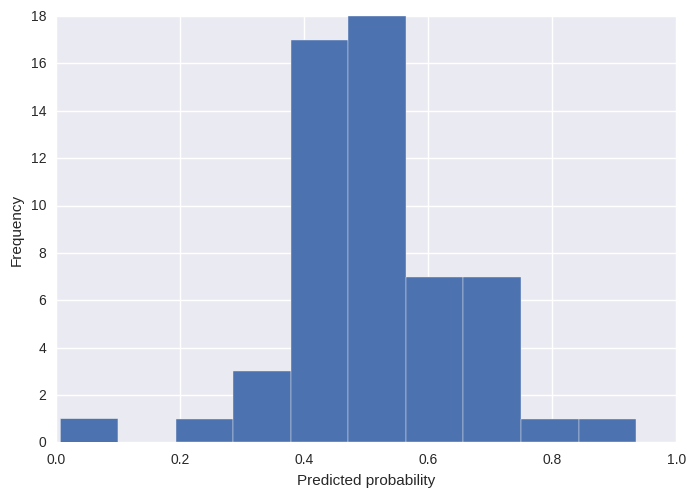

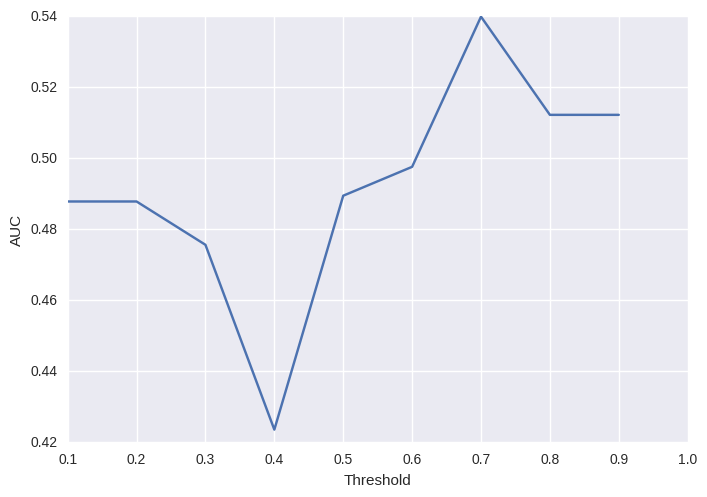

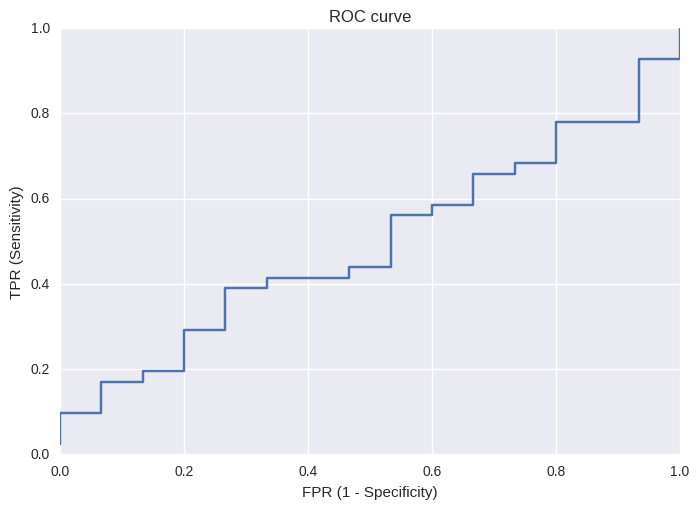

[[-0.44868634  0.27173386  0.          0.          0.28961682  0.
  -0.69410129  0.          0.05813076  0.          0.        ]]


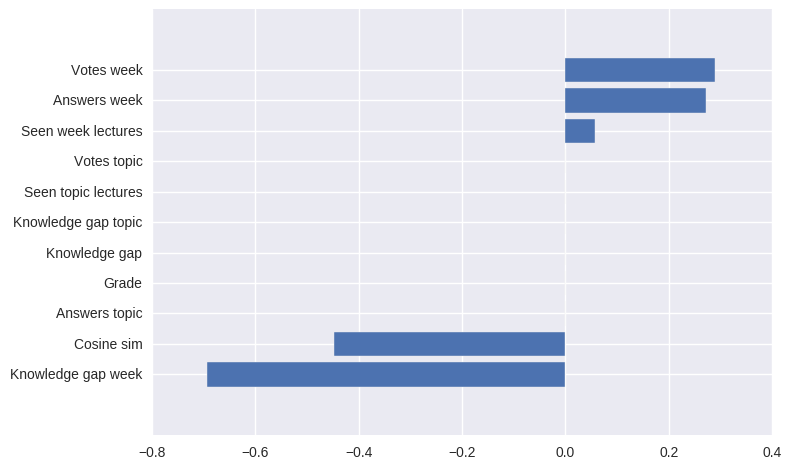

In [7]:
classifier = SGDClassifier()
PARAM_GRID = {
            "clf__n_iter": [10, 100, 500],
            "clf__alpha": [1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4],
            "clf__loss": ["log"],
            "clf__class_weight": ["balanced"],
            "clf__penalty": ["l1","l2"],
            "clf__random_state": [42]
}

clf = evaluate_classifier(classifier, X, Y, PARAM_GRID, 6)
# Plot feature importances
print(clf.named_steps['clf'].coef_)
features_importances(clf.named_steps['clf'].coef_.reshape(clf.named_steps['clf'].coef_.shape[1],), 
                     exp_data.drop('Class', axis=1))

Grid searching...
Model with rank: 1
Mean validation score: 0.590 (std: 0.044)
Parameters: {'clf__gamma': 0.01, 'clf__probability': True, 'clf__random_state': 42, 'clf__C': 10.0, 'clf__class_weight': 'balanced', 'clf__kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.585 (std: 0.069)
Parameters: {'clf__gamma': 0.001, 'clf__probability': True, 'clf__random_state': 42, 'clf__C': 100.0, 'clf__class_weight': 'balanced', 'clf__kernel': 'sigmoid'}

Model with rank: 3
Mean validation score: 0.578 (std: 0.095)
Parameters: {'clf__gamma': 0.1, 'clf__probability': True, 'clf__random_state': 42, 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__kernel': 'rbf'}

(array([ 0.38888889,  0.85714286]), array([ 0.77777778,  0.52173913]), array([ 0.51851852,  0.64864865]), array([ 9, 23]))
(array([ 1.        ,  0.74193548]), array([ 0.11111111,  1.        ]), array([ 0.2       ,  0.85185185]), array([ 9, 23]))
(array([ 0.        ,  0.73333333]), array([ 0.,  1.]), array([ 0.        ,  0.84615

/home/dmacjam/anaconda3/envs/askalot/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dmacjam/anaconda3/envs/askalot/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([ 0.66666667,  0.83333333]), array([ 0.5       ,  0.90909091]), array([ 0.57142857,  0.86956522]), array([ 8, 22]))
(array([ 0.45454545,  0.84210526]), array([ 0.625     ,  0.72727273]), array([ 0.52631579,  0.7804878 ]), array([ 8, 22]))
(array([ 0.        ,  0.73333333]), array([ 0.,  1.]), array([ 0.        ,  0.84615385]), array([ 8, 22]))
6-fold AUC: 0.60 (+/- 0.08)
6-fold F1: 0.67 (+/- 0.06)


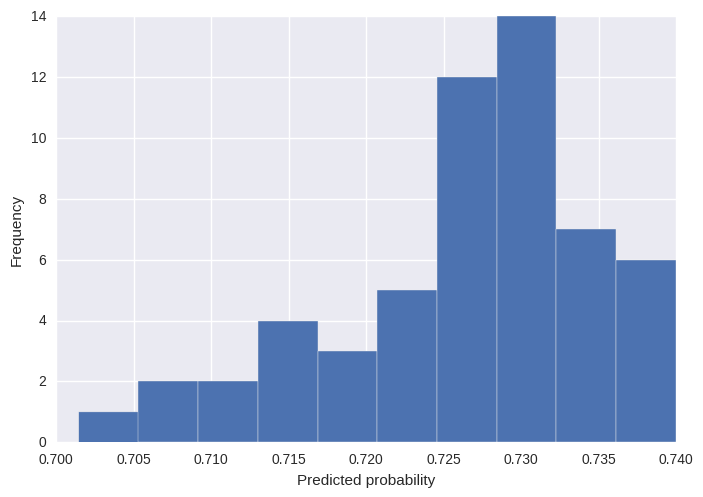

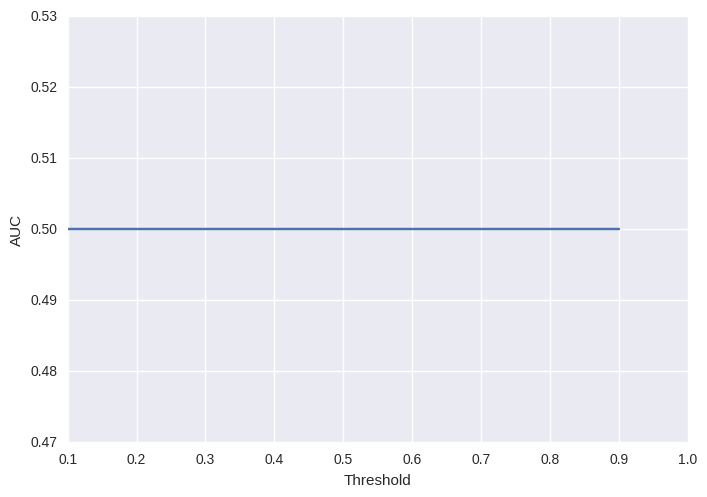

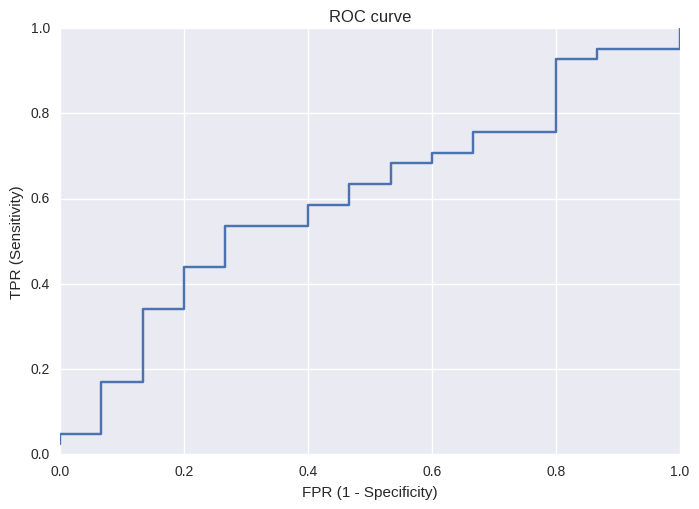

In [8]:
classifier = svm.SVC()
PARAM_GRID = {
            "clf__C": [1e-2, 1e-1, 1, 1e1, 1e2],
            "clf__gamma": [1e-3,1e-2,1e-1],
            "clf__kernel": ["rbf", "sigmoid", "linear"],
            "clf__class_weight": ["balanced"],
            "clf__probability": [True],
            "clf__random_state": [42]
}

clf = evaluate_classifier(classifier, X, Y, PARAM_GRID, 6)

## Willingess features

In [9]:
wil_features = ['Answers count', 'Comments count','Recent answers count', 'Votes count', 'Last answer', 
                'Seen week lectures', 'Seen topic lectures', 'Lecture freshness',
                'Avg CQA activity', 'Avg course activity', 'Seen week questions', 'Seen topic questions',
                'Questions count', 'Registration date']
wil_baseline_features = ['Answers count', 'Comments count','Recent answers count', 'Votes count', 
                         'Avg CQA activity', 'Questions count', 'Registration date']
wil_data = read_csv(path_data+'willingness-train.dat', delimiter=' ', header=None, 
                    names = ['Class']+wil_features)
#wil_data.head()
describe_dataset(wil_data['Class'])
wil_data.describe()

Original dataset shape Counter({0: 13475, 1: 891})


,Class,Answers count,Comments count,Recent answers count,Votes count,Last answer,Seen week lectures,Seen topic lectures,Lecture freshness,Avg CQA activity,Avg course activity,Seen week questions,Seen topic questions,Questions count,Registration date
count,14366.000000,14366.000000,14366.000000,14366.000000,14366.000000,1.436600e+04,14366.000000,14366.000000,1.436600e+04,14366.000000,14366.000000,14366.000000,14366.000000,14366.000000,1.436600e+04
mean,0.062021,3.625853,3.634971,2.001810,2.989698,3.600446e+05,1.631672,1.938135,2.908615e+05,0.302151,0.134119,0.562890,0.764244,1.496032,2.986793e+06
std,0.241203,9.296643,7.117627,4.108788,6.740666,7.910247e+05,3.033657,4.047751,6.578805e+05,0.284980,0.139200,1.113695,1.478140,2.740109,2.171146e+06
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,8.170615e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.074074,0.000000,0.026432,0.000000,0.000000,7.874112e+05
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.555556,0.750000,2.500000e+01,0.200000,0.095238,0.166667,0.222222,0.000000,3.117373e+06
75%,0.000000,3.000000,3.000000,2.000000,2.000000,2.351435e+05,2.285714,2.500000,2.605190e+05,0.466667,0.222222,0.625000,0.833333,2.000000,4.585848e+06
max,1.000000,81.000000,43.000000,28.000000,48.000000,7.157559e+06,52.333333,152.000000,4.664093e+06,1.000000,0.586207,12.555556,34.000000,21.000000,7.697303e+06


### Correlation between willingness input features

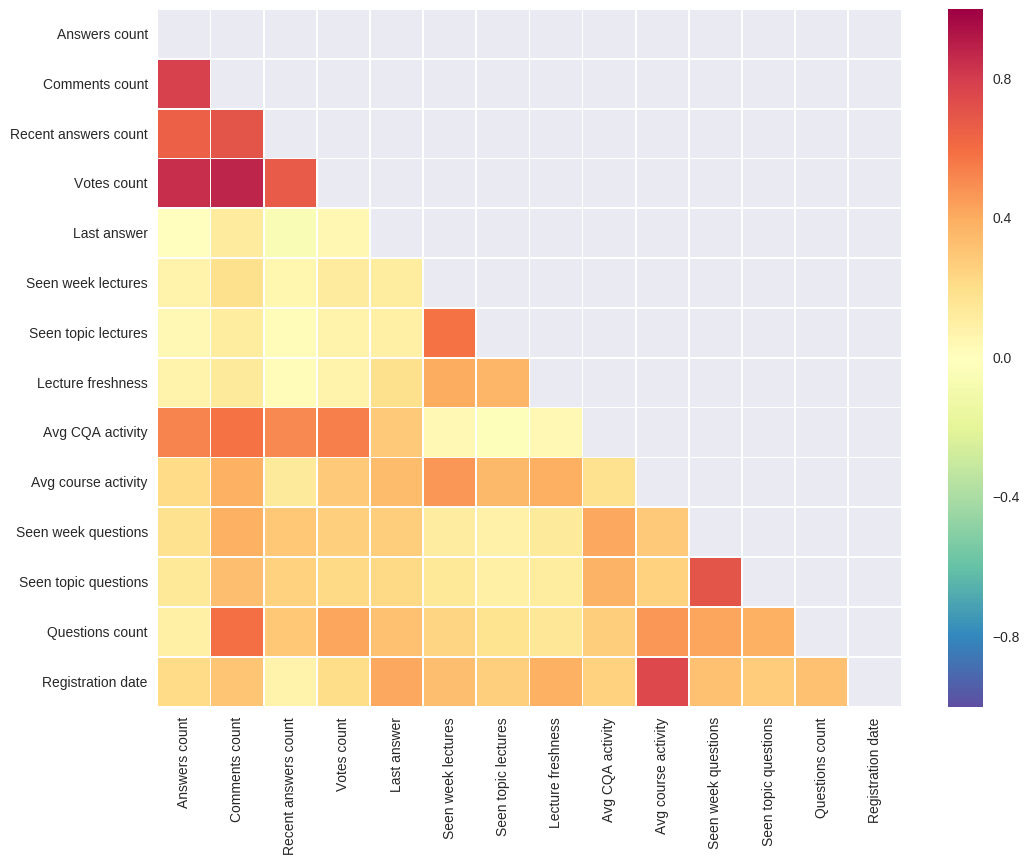

In [10]:
correlation_plot(wil_data.drop('Class', axis=1))

### ANOVA b

In [11]:
Y = wil_data['Class'].as_matrix()
X = wil_data.drop('Class', axis=1).as_matrix()
select_features(X,Y)

('ANOVA f-values: ', array([ 509.59430356,  491.59610792,  579.87653275,  603.33171533,
          4.50130303,    3.70789648,    4.53824316,    2.25205852,
        114.30833608,    9.49856176,   54.75526106,  221.70024669,
        178.21867472,    7.74720354]))
('ANOVA p-values: ', array([  6.54215353e-111,   3.97993046e-107,   1.21562596e-125,
         1.53039848e-130,   3.38861088e-002,   5.41753174e-002,
         3.31625360e-002,   1.33458771e-001,   1.40410749e-026,
         2.06022246e-003,   1.44078499e-013,   9.04860337e-050,
         2.06608832e-040,   5.38660693e-003]))


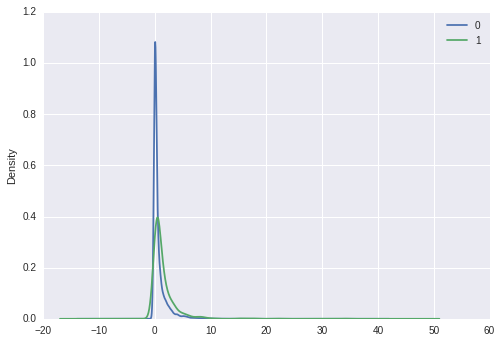

In [228]:
plt.figure()
wil_data.groupby('Class')['Seen topic questions'].plot(kind='density', legend=True)
plt.show()

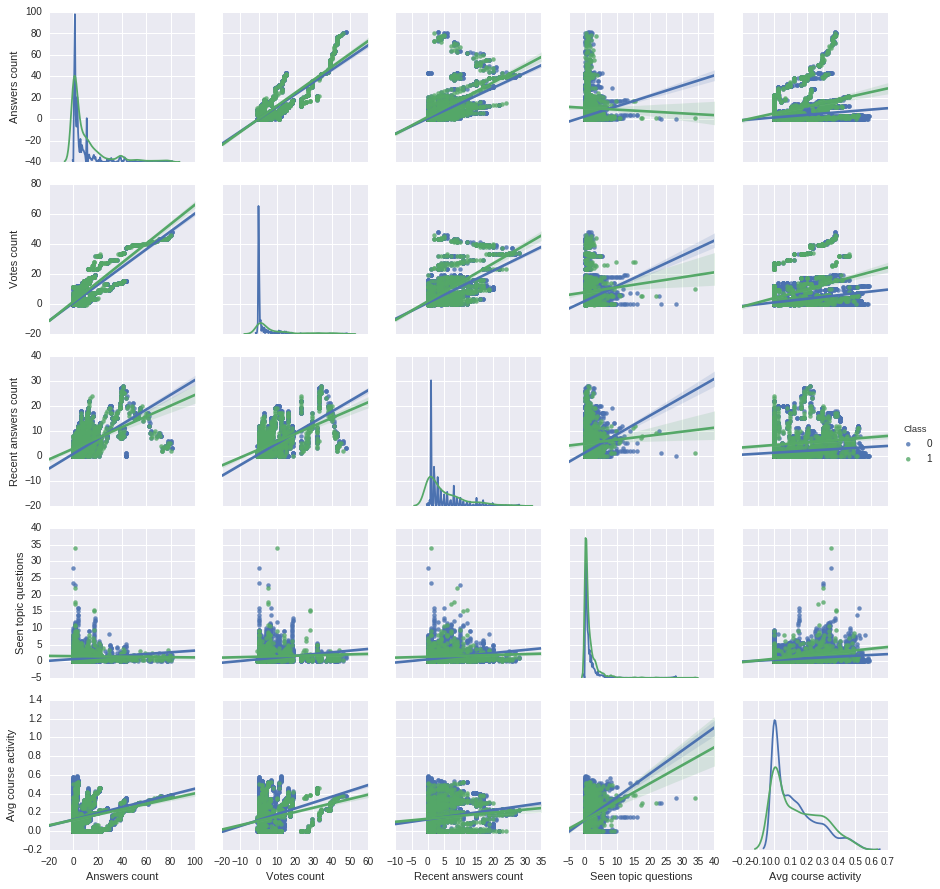

In [238]:
sns.pairplot(wil_data, hue="Class", vars=["Answers count", "Votes count", "Recent answers count",
            'Seen topic questions', "Avg course activity"], 
             kind="reg", diag_kind="kde")

### Willingness training

Grid searching...
Model with rank: 1
Mean validation score: 0.722 (std: 0.061)
Parameters: {'clf__criterion': 'gini', 'clf__class_weight': 'balanced', 'clf__random_state': 42, 'clf__oob_score': True, 'clf__n_estimators': 200, 'clf__max_depth': 2}

Model with rank: 2
Mean validation score: 0.719 (std: 0.055)
Parameters: {'clf__criterion': 'entropy', 'clf__class_weight': 'balanced', 'clf__random_state': 42, 'clf__oob_score': True, 'clf__n_estimators': 100, 'clf__max_depth': 3}

Model with rank: 3
Mean validation score: 0.719 (std: 0.061)
Parameters: {'clf__criterion': 'entropy', 'clf__class_weight': 'balanced', 'clf__random_state': 42, 'clf__oob_score': True, 'clf__n_estimators': 200, 'clf__max_depth': 2}

(array([ 0.98022893,  0.14884696]), array([ 0.69881306,  0.78888889]), array([ 0.81593764,  0.25044092]), array([1348,   90]))
(array([ 0.96881497,  0.12421053]), array([ 0.69139466,  0.66292135]), array([ 0.80692641,  0.20921986]), array([1348,   89]))
(array([ 0.99075975,  0.17278618

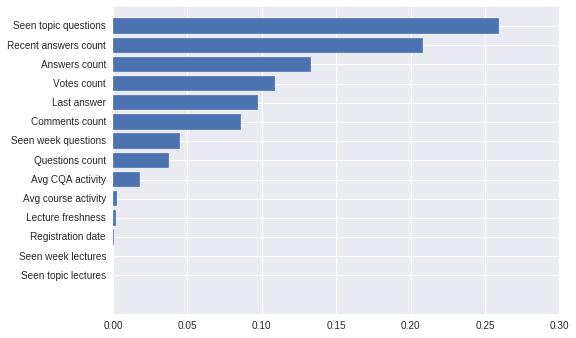

In [233]:
Y = wil_data['Class'].as_matrix()
X = wil_data.drop('Class', axis=1).as_matrix()

classifier = RandomForestClassifier()
PARAM_GRID = {
            "clf__n_estimators": [60, 100, 200],
            "clf__criterion": ["gini", "entropy"],
            "clf__max_depth": [2, 3, 4, 6, 8],
            "clf__oob_score": [True],
            "clf__class_weight": ["balanced"],
            "clf__random_state": [42]
}

clf = evaluate_classifier(classifier, X, Y, PARAM_GRID, 10)
print('OOB Score:', clf.named_steps['clf'].oob_score_)
# Plot feature importances
features_importances(clf.named_steps['clf'].feature_importances_, wil_data.drop('Class', axis=1))

Grid searching...
Model with rank: 1
Mean validation score: 0.694 (std: 0.057)
Parameters: {'clf__n_iter': 10, 'clf__class_weight': 'balanced', 'clf__random_state': 42, 'clf__alpha': 0.01, 'clf__loss': 'log', 'clf__penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.693 (std: 0.066)
Parameters: {'clf__n_iter': 500, 'clf__class_weight': 'balanced', 'clf__random_state': 42, 'clf__alpha': 0.0001, 'clf__loss': 'log', 'clf__penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.692 (std: 0.052)
Parameters: {'clf__n_iter': 10, 'clf__class_weight': 'balanced', 'clf__random_state': 42, 'clf__alpha': 0.001, 'clf__loss': 'log', 'clf__penalty': 'l1'}

(array([ 0.97077244,  0.12916667]), array([ 0.68991098,  0.68888889]), array([ 0.8065915 ,  0.21754386]), array([1348,   90]))
(array([ 0.97444089,  0.13052209]), array([ 0.67878338,  0.73033708]), array([ 0.8001749 ,  0.22146508]), array([1348,   89]))
(array([ 0.98502994,  0.17011494]), array([ 0.73219585,  0.83146067]), array([ 0.8

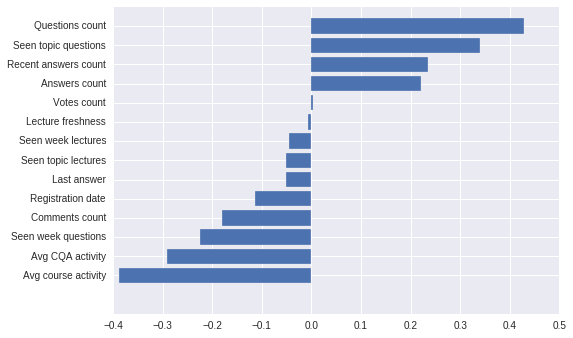

In [231]:
Y = wil_data['Class'].as_matrix()
X = wil_data.drop('Class', axis=1).as_matrix()

classifier = SGDClassifier()
PARAM_GRID = {
            "clf__n_iter": [10, 100, 500],
            "clf__alpha": [1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4],
            "clf__loss": ["log"],
            "clf__class_weight": ["balanced"],
            "clf__penalty": ["l1","l2"],
            "clf__random_state": [42]
}

clf = evaluate_classifier(classifier, X, Y, PARAM_GRID, 10)
# Plot feature importances
print(clf.named_steps['clf'].coef_)
features_importances(clf.named_steps['clf'].coef_.reshape(clf.named_steps['clf'].coef_.shape[1],), 
                     wil_data.drop('Class', axis=1))

In [241]:
Y = wil_data['Class'].as_matrix()
X = wil_data.drop('Class', axis=1).as_matrix()

classifier = svm.SVC()
PARAM_GRID = {
            "clf__C": [1e-2],
            "clf__gamma": [1e-1],
            "clf__kernel": ["rbf"],
            "clf__class_weight": ["balanced"],
            "clf__probability": [True],
            "clf__random_state": [42]
}

clf = evaluate_classifier(classifier, X, Y, PARAM_GRID, 10)

Grid searching...
Model with rank: 1
Mean validation score: 0.662 (std: 0.070)
Parameters: {'clf__kernel': 'rbf', 'clf__class_weight': 'balanced', 'clf__random_state': 42, 'clf__C': 0.01, 'clf__gamma': 0.1, 'clf__probability': True}

(array([ 0.97578204,  0.14765101]), array([ 0.71735905,  0.73333333]), array([ 0.82684908,  0.24581006]), array([1348,   90]))
(array([ 0.97045952,  0.11854685]), array([ 0.65801187,  0.69662921]), array([ 0.78426172,  0.20261438]), array([1348,   89]))
(array([ 0.99013158,  0.15238095]), array([ 0.66988131,  0.8988764 ]), array([ 0.79911504,  0.26058632]), array([1348,   89]))
(array([ 0.98113208,  0.18302387]), array([ 0.77151335,  0.7752809 ]), array([ 0.86378738,  0.29613734]), array([1348,   89]))
(array([ 0.96999032,  0.14356436]), array([ 0.74332344,  0.65168539]), array([ 0.84166317,  0.23529412]), array([1348,   89]))
(array([ 0.95934959,  0.09391304]), array([ 0.61321455,  0.60674157]), array([ 0.74818841,  0.1626506 ]), array([1347,   89]))
(arr

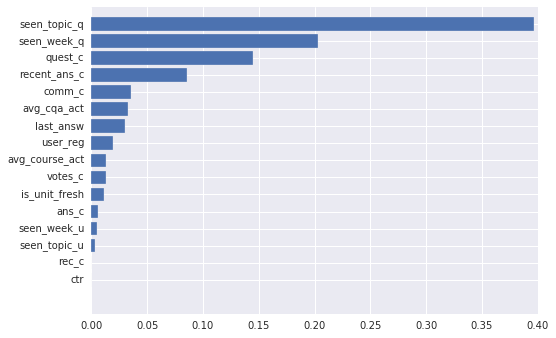

/home/dmacjam/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dmacjam/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dmacjam/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dmacjam/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dmacjam/anaconda3/lib/python3.5/site-packages/skle

[array([ 0.12      ,  0.11640212,  0.10459588,  0.13017751,  0.15034169,
        0.11913357,  0.10328638,  0.11827957,  0.1007874 ,  0.09831029]), array([ 0.13778706,  0.12619503,  0.11458333,  0.13924051,  0.1598063 ,
        0.14831461,  0.11978221,  0.12865497,  0.114082  ,  0.10666667]), array([ 0.13924051,  0.12355212,  0.12      ,  0.13983051,  0.16058394,
        0.15102975,  0.12692308,  0.13646055,  0.124     ,  0.11615245]), array([ 0.12280702,  0.11160714,  0.11313869,  0.1358811 ,  0.15538847,
        0.15856777,  0.15041783,  0.18181818,  0.14187643,  0.14251781]), array([ 0.14159292,  0.12921348,  0.12293144,  0.19858156,  0.27586207,
        0.17532468,  0.15254237,  0.19649123,  0.15151515,  0.1459854 ]), array([ 0.125     ,  0.08026756,  0.06266319,  0.17894737,  0.29126214,
        0.12149533,  0.11428571,  0.18367347,  0.1299639 ,  0.1512605 ]), array([ 0.1125    ,  0.05128205,  0.00803213,  0.        ,  0.        ,
        0.        ,  0.01960784,  0.04761905,  0.10

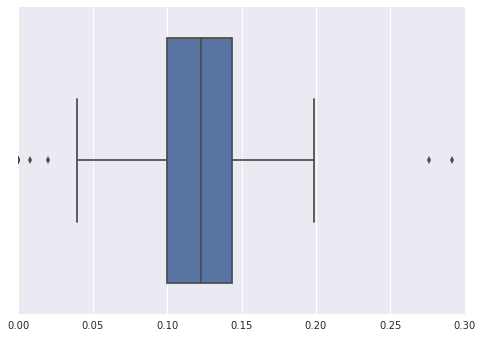

In [49]:
X = wil_data.drop('class', axis=1)
Y = wil_data['class']
clf = RandomForestClassifier(n_estimators=25, max_depth=4, class_weight="balanced", n_jobs=-1,
                                        random_state=42, criterion="entropy")

scaler = preprocessing.RobustScaler()
pipelined_clf = Pipeline([('Scaling', scaler), ('Classifier', clf)])

pipelined_clf.fit(X, Y)

features_importances(pipelined_clf.named_steps['Classifier'], wil_data.drop('class', axis=1))

def custom_f1(threshold):
    def f1_cutoff(clf, X, Y):
        ypred = (clf.predict_proba(X)[:,1] > threshold).astype(int)
        return metrics.f1_score(Y, ypred)
    return f1_cutoff

scores = []
for threshold in np.arange(0.1, 0.9, 0.1):
    validated = cross_val_score(pipelined_clf, X, Y,cv=10, scoring=custom_f1(threshold))
    scores.append(validated)
    
sns.boxplot(scores, names=np.arange(0.1, 0.9, 0.1))
plt.show()

## Ensemble classification

In [ ]:
def predict(self, exp_clf, will_clf, X_exp, X_will):
    exp_predictions = self.exp_clf.predict(X_exp)
    will_predictions = self.will_clf.predict(X_will)

    indices = [ind for ind, (i, j) in enumerate(zip(exp_predictions, will_predictions))]
    probabilities = exp_predictions[indices] * will_predictions[indices]

    # Sort descending based on probabilies array
    i = np.array(probabilities).argsort()[::-1]
    indices = np.array(indices)[i]
    return indices, exp_predictions, will_predictions

In [ ]:
# TODO spravit cez experimentalnu infrastrukturu

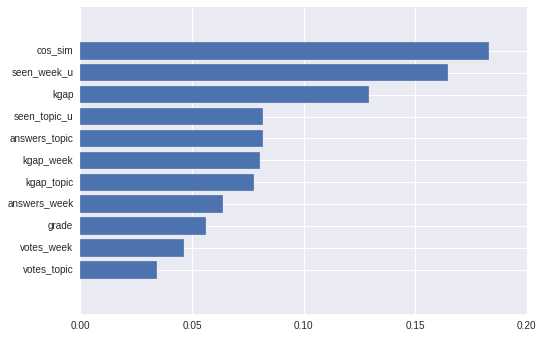

{'clf': RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='entropy', max_depth=6, max_features='auto',
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'clf__bootstrap': True,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'entropy',
 'clf__max_depth': 6,
 'clf__max_features': 'auto',
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_split': 1e-07,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 20,
 'clf__n_jobs': -1,
 'clf__oob_score': False,
 'clf__random_state': None,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True),
 'scaler__copy': Tr

In [10]:
# Load trained expertise classifier.
expertise_clf_filename = path+'expertise-classifier.pkl'
exp_clf = joblib.load(expertise_clf_filename)
features_importances(exp_clf.named_steps['clf'], exp_features)
exp_clf.get_params()

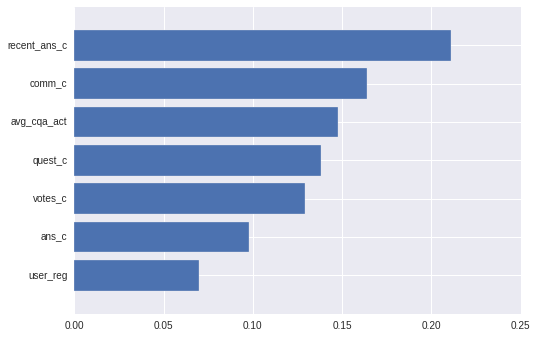

{'clf': RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='entropy', max_depth=4, max_features='auto',
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'clf__bootstrap': True,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'entropy',
 'clf__max_depth': 4,
 'clf__max_features': 'auto',
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_split': 1e-07,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 20,
 'clf__n_jobs': -1,
 'clf__oob_score': False,
 'clf__random_state': None,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True),
 'scaler__copy': Tr

In [27]:
# Load trained willingness classifier.
willigness_clf_filename = '/media/dmacjam/Data disc1/git/Askalot-dev/askalot/recommendation/willingness-baseline-classifier.pkl'
will_clf = joblib.load(willigness_clf_filename)
features_importances(will_clf.named_steps['clf'], wil_baseline_features)
will_clf.get_params()

## Ensemble evaluation

In [11]:
N = 100
evaluation_features = ['S@N','P@N','AP@N','RR@N', 'NDCG@N']
full_evaluation_data = read_csv(path_data+'full-evaluation-'+str(N)+'.dat', delimiter='\t', header=None, 
                           names = evaluation_features)
baseline_evaluation_data = read_csv(path_data+'baseline-evaluation-'+str(N)+'.dat', delimiter='\t', header=None, 
                           names = evaluation_features)

full_evaluation_data.describe()

,S@N,P@N,AP@N,RR@N,NDCG@N
count,263.000000,263.000000,263.000000,263.000000,263.000000
mean,0.923954,0.884030,0.259659,0.284399,0.412727
std,0.265576,0.287141,0.317589,0.340242,0.288174
min,0.000000,0.000000,0.000000,0.001669,0.000000
25%,1.000000,1.000000,0.040000,0.041667,0.218104
50%,1.000000,1.000000,0.125000,0.125000,0.315465
75%,1.000000,1.000000,0.333333,0.333333,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
baseline_evaluation_data.describe()

,S@N,P@N,AP@N,RR@N,NDCG@N
count,263.000000,263.000000,263.000000,263.000000,263.000000
mean,0.893536,0.857731,0.234157,0.258762,0.384163
std,0.309018,0.321286,0.302678,0.325838,0.283126
min,0.000000,0.000000,0.000000,0.002410,0.000000
25%,1.000000,1.000000,0.033908,0.038462,0.212746
50%,1.000000,1.000000,0.107143,0.111111,0.301030
75%,1.000000,1.000000,0.260417,0.333333,0.499581
max,1.000000,1.000000,1.000000,1.000000,1.000000
